<a href="https://colab.research.google.com/github/jhill1/hydrological_coastal_processes/blob/main/prac_1/Practical_1_Hydrology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Practical 1: Hydrology

Use LandLab to see what impact things like infiltration etc have on flow. This model doesn't simulate the flow in the river; just the run off during a heavy storm event. Forge Valley

No infiltration is like having hard surfaces (tarmac) or baked soil (e.g. after a wildfire). Low infiltration acts like the soil is already getting to capacity.

We'll look at the water discharge from the river as the surface water depth over the landscape.

plot graphs, copy and paste into a google doc or similar for notes. Title gives the key parameters used.


**What will you do and what is the point?**

The idea of this practical is to think about how a river system goes back into equilibrium following some change in the system. This is what we've been covering in the lectures. We will create a steady-state system, then perturb it to see how and how long it takes to go back into equilibrium.

In this exercise you will modify the code to alter rock uplift rates and patterns and the erodibility coefficient that controls fluvial channel form.

Start at the top by reading each block of text and sequentially running each code block (click the little "play" symbol on the left of a block of code).

If you just change one code block and rerun only that code block, only the parts of the code in that code block will be updated. For example, if you change parameters but don't reset the code blocks that initialize run time or topography, then these values will not be reset.

**What to do..**

Run each block of code once until you get to the text that says **stop here**. Then stop, and read the instrucitons carefullly! Make sure there are no errors. Ask for help if things don't work.


In [2]:
# this code install landlab and necessary things. You only need to do this once.
!pip install landlab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 60.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.5 MB/s eta 0:00:00
  Created wheel for bmipy: filename=bmipy-2.0-py3-none-any.whl size=7223 sha256=e756358bb96c17ee52c6df224e4a3e2991aa6666deff21ae4f2e576db6605251
  Stored in directory: /root/.cache/pip/wheels/0e/57/6e/10a9cc7a74e618ab8d0c85dc08080b98dfe353af44ad85c7f6
Successfully built bmipy


In [3]:
# Code Block 1
from landlab import RasterModelGrid, imshow_grid
from landlab.components.overland_flow import LinearDiffusionOverlandFlowRouter
from landlab.io import read_esri_ascii
import numpy as np
from matplotlib import pyplot as plt
#below is to make plots show up in the notebook
%matplotlib inline

In [4]:
# Code Block 2

# We also need to upload our two DEM (digital Elevation Model) files (.asc).
# Run this code and select the DEM file using the button that appears
from google.colab import files
uploaded = files.upload()

KeyboardInterrupt: ignored

In [10]:
# Code Block 3

(demgrid, demelev) = read_esri_ascii(
    "FV_10m_DEM_filled_sml.asc", name="topographic__elevation"
)
# Create Landlab model grid and assign the DEM elevations to it,
# then display the terrain.
# (note: DEM horizontal and vertical units are meters)
grid = RasterModelGrid(
    (demgrid.number_of_node_rows, demgrid.number_of_node_columns), xy_spacing=demgrid.dx
)
elev = grid.add_zeros("topographic__elevation", at="node")
elev[:] = demelev
imshow_grid(grid, elev, colorbar_label="Elevation (m)")
scaling = 3600*1000

FileNotFoundError: ignored

In [9]:
# Code Block 4

# Process parameters
n = 0.025  # roughness coefficient, (s/m^(1/3))
uc = 1.0  # characteristic velocity scale (m/s)
R1 = 72.0 # Initial rainfall (storm event) mm/hr
R2 = 0.0  # Rainfall after event mm/hr
infilt_cap = 0  # infiltration capacity, mm/hr

# scale parameters to m/s
R1 = R1 / scaling
R2 = R2 / scaling
infilt_cap = infilt_cap / scaling

# Run-control parameters
heavy_rain_duration = 300.0  # duration of heavy rainfall, s
run_time = 3600.0  # duration of run, s
dt = 10.0  # time-step size, s

# Derived parameters
num_steps = int(run_time / dt)

# set up arrays to hold discharge, time, and rain rate
time_since_storm_start = np.linspace(0.0, run_time, num_steps + 1)
discharge = np.zeros(num_steps + 1)
rain_rate = np.zeros(num_steps + 1)
rain_rate[:] = R1
rain_rate[time_since_storm_start >= heavy_rain_duration] = R2

# plot the rainfall
plt.plot(time_since_storm_start / 60.0, rain_rate * scaling)
plt.xlabel("Time (min)")
plt.ylabel("Rainfall (mm/hr)")
plt.grid(True)

params_message = "R1: {r1}, R2: {r2}, Infiltration: {ic}, n: {n}".format(r1=R1*scaling, r2=R2*scaling, ic=infilt_cap*scaling, n=n)

NameError: ignored

In [ ]:
# Code Block 5

# Configure the boundaries: valid bottom-edge nodes will be open;
grid.status_at_node[grid.nodes_at_bottom_edge] = grid.BC_NODE_IS_FIXED_VALUE
grid.status_at_node[np.isclose(elev, -9999.0)] = grid.BC_NODE_IS_CLOSED
indices = np.where(elev[grid.nodes_at_bottom_edge] > 0.0)[0]
outlet_nodes = grid.nodes_at_bottom_edge[indices]
links_at_outlets = grid.links_at_node[outlet_nodes]
links_to_track = links_at_outlets[
    grid.status_at_link[links_at_outlets] == grid.BC_LINK_IS_ACTIVE
].flatten()

In [ ]:
# Code Block 6

# Instantiate the component
olflow = LinearDiffusionOverlandFlowRouter(
    grid, rain_rate=R1, infilt_rate=infilt_cap, roughness=n, velocity_scale=1.0, cfl_factor = 0.75
)


In [ ]:
# Code Block 7

# clear everything and start running the simulation.
q = grid.at_link["water__specific_discharge"]
grid.at_node["surface_water__depth"][:] =  0.0
water_after_storm = grid.at_node["surface_water__depth"]

for i in range(num_steps):
    t = i * dt
    print("Time: ", t)
    olflow.rain_rate = rain_rate[i]
    olflow.run_one_step(dt)
    discharge[i + 1] = np.sum(np.abs(q[links_to_track])) * grid.dx
    if (t < heavy_rain_duration):
      water_after_storm =  np.copy(grid.at_node['surface_water__depth'])

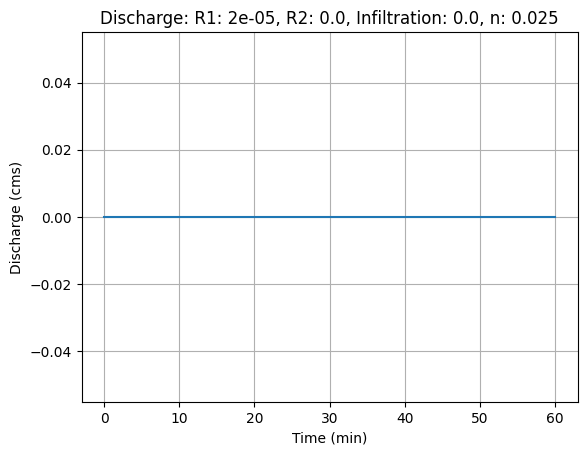

In [8]:
# Code Block 8

plt.plot(time_since_storm_start / 60.0, discharge)
plt.title("Discharge: "+params_message)
plt.xlabel("Time (min)")
plt.ylabel("Discharge (cms)")
plt.grid(True)

In [ ]:
# Code Block 9

fig = plt.figure()
fig.tight_layout()
fig.suptitle('Surface water depth')
fig.add_subplot(131)
imshow_grid(grid, water_after_storm, plot_name="At end of storm", cmap='Blues', vmax=0.75)
fig.add_subplot(132)
imshow_grid(grid, grid.at_node['surface_water__depth'], plot_name="At end of simulation", cmap='Blues', vmax=0.75)
fig.add_subplot(133)
plt.subplots_adjust(right=1.75)
imshow_grid(grid, grid.at_node['surface_water__depth']-water_after_storm, plot_name="Difference", cmap='seismic', symmetric_cbar=True)



In [ ]:
# Code Block 10

# store everything for comparison later
water_after_storm_orig = water_after_storm
water_after_hour = np.copy(grid.at_node['surface_water__depth'])
discharge_orig = discharge

**STOP HERE**

At this point you have a simulation that takes the basic DEM (topographic data) and simulates a heavy rainfall for 300 seconds (5 minutes) and then no rain to the end of the simulation (1 hour).

The simulation siomulates the flow of water overland, but we haven't added an infiltration into the soil (i.e. the land is completely impermeable). We also have a very low drag coefficient (equivalent to "clean sand" everywhere). For those on the rivers field trip a few weeks ago, does this sound realsitic?

Have a think about these questions and write down some answers:

1. Will the amount of surface water and discharge increase or decrease when infiltration rate is added to the model?
2. If the drag coefficient (Manning's) is increased, will that increase the discharge. How does increasing the drag coefficient interact with increased infilatration rate?
3. How do we change the drag coefficient and infiltration rate in reality? How does this effect management of catchments?

Now edit things:
* mannings (Original value: 0.025. Try 0.1 and 0.01)
* infiltration rate (Original value: 0. Try 10, 30 mm/hr)
* storm intensity (72 mm/hr. Try 10 and 30 mm/hr)
* storm length (300 s, try 1200 and 900)

NOTE: For the rest of the questions you should use Code Blocks 13-19. These will allow you to use the steady-state landscape created for question 1 - referred to here as the 'base landscape' - as the initial condition. Run Code block 13, which creates copies of that initial landscape. Then start by editing what you need to in Code Blocks 14 - 16. Run these each once, sequentially. You can run Code Block 16, the time loop, as many times as you need to, along with Code Blocks 17-19, which produce plots.

For each question, re-run code block 13 to get back to that initial landscape. If it all goes wrong, start from code block 2, but you can edit the  tmax  parameter to get to steady state in one click...

Part 2. Transient landscape responding to an increase in rock uplift.

Use the base landscape and increase rock uplift uniformly by a factor of 4 to 0.0004 m/yr. Make sure you update the rock uplift rate (Code Block 15) and ensure that  tmax  is 1e5 yrs and  dt  is 500 yrs (Code Block 14). Run this until the maximum elevation in the grid is ~ 250 m and observe how the landscape gets to this elevation, i.e. plot intermediate steps. What patterns do you see in the supporting plots that illustrate this type of transient? What aspects of the landscape have changed in comparison with the base landscape from question 1?

Part 3. Increase erodibility. Start again from the base landscape (i.e. re-run code block 13), but this time increase  Ksp  to 2E-5 (Code Block 13). Make sure rock uplift rate is set to the original value of 0.0001 m/yr (Code Block 15). Set  tmax  to 1e5 yrs (Code Block 14). Run for 1e5 yrs and save the plots that you think are diagnostic. Run for another 1e5 yrs and save plots again. Now run for 5e5 yrs and save plots again. Quantitatively describe how the landscape evolves in response to the increase in erodibility and provide supporting plots. What could cause a uniform increase in erodibility?

Part 4. Spatially varible uplift - discrete, massive earthquake. Start again from the base landscape (Code Block 13), and make sure that  Ksp  = 1E-5. Now add a seismic event to this steady state landscape - a fault that runs horizontally across the landscape at y = 4000 m, and instantaneously uplifts half the landscape by 10 meters (Code Block 15 - uncomment the five lines in the first IMPORTANT comment block). In this case, we will keep background uplift uniform at 0.0001 m/yr. Set  tmax  to 1e5 yrs and  dt  to 500 yrs (Code Block 15) before evolving the landscape after the fault. Now run the time loop four times and look at the different plots after each loop. How does the landscape respond to this fault? What patterns do you see in the supporting plots that illustrate this type of transient? Which patterns, if any, are diagnostic of a channel response to an earthquake?

Part 5. Final Reflection. Was your initial insight into how parameters would effect the landscape correct?

Feel free to play around some more. How might uplift rate increase and erodibility change play out if they happen at the same time? How might we differentiate between these things happening? Code block 15 also has different uplift functions (differential uplift along a fault and whole landscape differential uplift)

In [ ]:


# Process parameters
n = 0.025  # roughness coefficient, (s/m^(1/3))
uc = 1.0  # characteristic velocity scale (m/s)
R1 = 72.0 / (3600.0 * 1000.0)  # initial rainfall rate, m/s (converted from mm/hr)
R2 = 5.0 / (3600.0 * 1000.0)  # later rainfall rate, m/s (converted from mm/hr)
infilt_cap = 10.0 / (3600 * 1000.0)  # infiltration capacity, m/s (converted from mm/hr)

# convert unit (divide by 3600*1000)

# Run-control parameters
heavy_rain_duration = 300.0  # duration of heavy rainfall, s
run_time = 3600.0  # duration of run, s
dt = 10.0  # time-step size, s

# Derived parameters
num_steps = int(run_time / dt)

# set up arrays to hold discharge, time, and rain rate
time_since_storm_start = np.linspace(0.0, run_time, num_steps + 1)
discharge = np.zeros(num_steps + 1)
rain_rate = np.zeros(num_steps + 1)
rain_rate[:] = R1
rain_rate[time_since_storm_start >= heavy_rain_duration] = R2

# Instantiate the component
olflow = LinearDiffusionOverlandFlowRouter(
    grid, rain_rate=R1, infilt_rate=infilt_cap, roughness=n, velocity_scale=1.0, cfl_factor = 0.75
)


In [ ]:
# run sim block
q = grid.at_link["water__specific_discharge"]
grid.at_node["surface_water__depth"][:] =  0.0
water_after_storm = grid.at_node["surface_water__depth"]

for i in range(num_steps):
    t = i * dt
    print("Time: ", t)
    olflow.rain_rate = rain_rate[i]
    olflow.run_one_step(dt)
    discharge[i + 1] = np.sum(np.abs(q[links_to_track])) * grid.dx
    if (t < heavy_rain_duration):
      water_after_storm =  np.copy(grid.at_node['surface_water__depth'])

In [ ]:
# produce hydrograph plots (diff lines)
plt.plot(time_since_storm_start / 60.0, discharge, label="This run")
plt.plot(time_since_storm_start / 60.0, discharge_orig, label="Orig run")
plt.legend()
plt.xlabel("Time (min)")
plt.ylabel("Discharge (cms)")
plt.grid(True)

In [ ]:
# Produce water depth plot (2x2; orig on top, new on bottom)
fig = plt.figure()
fig.tight_layout()
fig.suptitle('Surface water depth')
fig.add_subplot(131)
imshow_grid(grid, water_after_storm, plot_name="At end of storm", cmap='Blues', vmax=0.75)
fig.add_subplot(132)
imshow_grid(grid, grid.at_node['surface_water__depth'], plot_name="At end of simulation", cmap='Blues', vmax=0.75)
fig.add_subplot(133)
plt.subplots_adjust(right=1.75)
imshow_grid(grid, grid.at_node['surface_water__depth']-water_after_storm, plot_name="Difference", cmap='seismic', symmetric_cbar=True)
